In [ ]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
pip install yfinance

Enter the ticker symbol (e.g., ^GSPC for S&P 500): ^GSPC


[*********************100%***********************]  1 of 1 completed

Fetching data for: ^GSPC
ARIMA 5-step forecast: 2024-01-01    0.987123
2024-02-01    0.984336
2024-03-01    0.985690
2024-04-01    0.985778
2024-05-01    0.985657
Freq: MS, Name: predicted_mean, dtype: float64
Training LSTM on input shape: (283, 5, 1)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


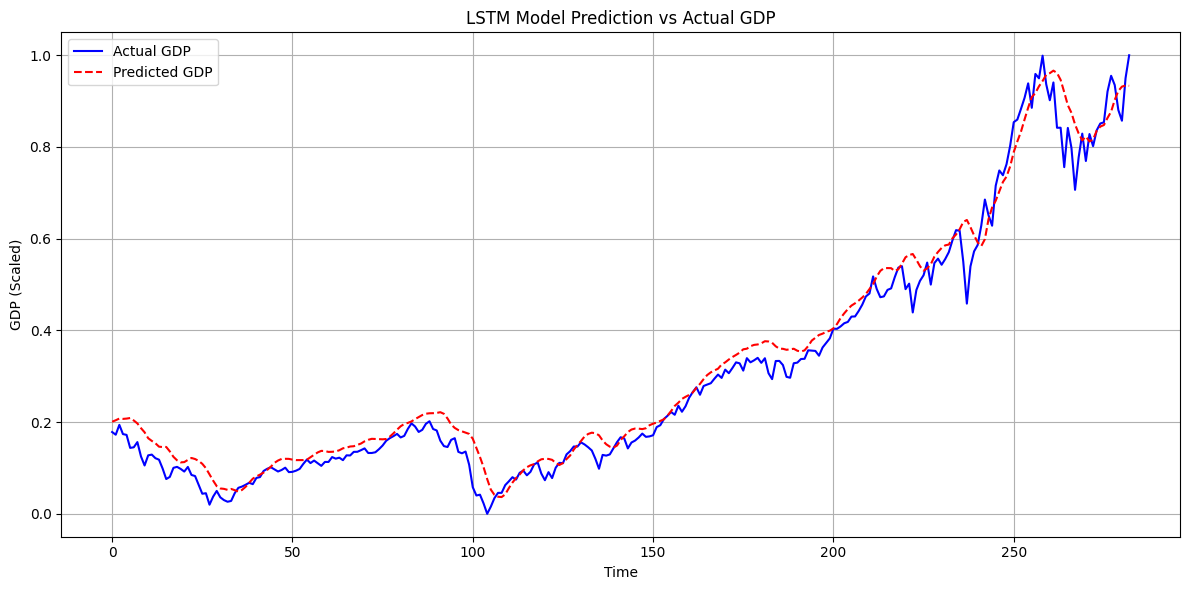

Optimal Tax Policy (Game Theory): 0.1539
Best Dynamic Tax Policy (Reinforcement Learning): 0.5000
LSTM Model R² Approximation: 97.65%


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_constraints.py:433: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lb = np.array([float(_arr_to_scalar(x)) if x is not None else -np.inf
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_constraints.py:435: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ub = np.array([float(_arr_to_scalar(x)) if x is not None else np.inf


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import random
import yfinance as yf
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# User input for ticker
ticker = input("Enter the ticker symbol (e.g., ^GSPC for S&P 500): ").strip().upper()

# Automatically correct common mistakes for indices
if ticker in ["GSPC", "DJI", "IXIC"]:
    ticker = "^" + ticker

print(f"Fetching data for: {ticker}")

# Fetching economic data using yfinance
data = yf.download(ticker, start="2000-01-01", end="2024-01-01", interval="1mo")

if data.empty:
    print(f"Error: No data found for ticker symbol '{ticker}'. Please check the ticker and try again.")
    exit()

# Prepare and clean data
data = data[['Close']]
data.rename(columns={'Close': 'GDP'}, inplace=True)
data.dropna(inplace=True)
data['Tax_Compliance'] = np.random.uniform(0.5, 1.0, size=len(data))

# Feature scaling
scaler = MinMaxScaler()
data['GDP'] = scaler.fit_transform(data[['GDP']])

def arima_forecast(data):
    model = sm.tsa.ARIMA(data['GDP'], order=(2,1,0))
    results = model.fit()
    forecast = results.forecast(steps=5)
    return forecast

def build_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(5, 1), activation='tanh', recurrent_activation='sigmoid'),
        LSTM(50, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

def evaluate_model(model, data):
    data_values = data['GDP'].values
    if len(data_values) <= 6:
        print("Not enough data points to train the LSTM model.")
        return 0

    X, y = [], []
    for i in range(len(data_values) - 5):
        X.append(data_values[i:i+5])
        y.append(data_values[i+5])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1)).astype(np.float32)

    print(f"Training LSTM on input shape: {X.shape}")
    model.fit(X, y, epochs=10, batch_size=1, verbose=0)

    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    accuracy = 1 - (mse / np.var(y))
    accuracy = max(0, accuracy) * 100

    # Plot actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Actual GDP', color='blue')
    plt.plot(predictions, label='Predicted GDP', color='red', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('GDP (Scaled)')
    plt.title('LSTM Model Prediction vs Actual GDP')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return accuracy

def game_theory(tax_rate, gdp, compliance):
    taxpayer_behavior = lambda x: np.exp(-tax_rate * x) * compliance
    revenue = lambda x: tax_rate * x * taxpayer_behavior(x) * gdp
    # Changed x0 to be a scalar instead of a list
    result = minimize(lambda x: -revenue(x), x0=0.2 * gdp, bounds=[(0.1 * gdp, 0.5 * gdp)])
    return result.x[0] if result.success else None

def reinforcement_learning():
    tax_policy = np.linspace(0.1, 0.5, 10)
    best_policy = None
    # Changed from data['GDP'].mean() to data['GDP'].mean().item()
    # to get a single numerical value for best_revenue
    best_revenue = -np.inf
    gdp = data['GDP'].mean().item() # Changed this line to get a single value
    for rate in tax_policy:
        compliance = random.uniform(0.5, 1.0)
        revenue = rate * gdp * compliance
        if revenue > best_revenue:
            best_revenue = revenue
            best_policy = rate
    return best_policy

# Run simulations
forecast = arima_forecast(data)
print(f"ARIMA 5-step forecast: {forecast}")

lstm_model = build_lstm_model()
accuracy = evaluate_model(lstm_model, data)

optimal_tax = game_theory(0.2, data['GDP'].mean(), data['Tax_Compliance'].mean())
best_tax_policy = reinforcement_learning()

print(f"Optimal Tax Policy (Game Theory): {optimal_tax:.4f}")
print(f"Best Dynamic Tax Policy (Reinforcement Learning): {best_tax_policy:.4f}")
print(f"LSTM Model R\u00b2 Approximation: {accuracy:.2f}%")


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

# User-defined or default ticker
ticker = input("Enter the ticker symbol (e.g., ^GSPC for S&P 500): ").strip().upper()
if ticker in ["GSPC", "DJI", "IXIC"]:
    ticker = "^" + ticker

# Fetch monthly close prices from Yahoo Finance
print(f"Fetching data for: {ticker}")
data = yf.download(ticker, start="2000-01-01", end="2024-01-01", interval="1mo")

# Handle empty case
if data.empty:
    raise ValueError(f"No data found for ticker symbol '{ticker}'.")

# Keep only 'Close' column, rename it to 'GDP' for simulation purposes
df = data[['Close']].copy()
df.rename(columns={'Close': 'GDP'}, inplace=True)

# Add synthetic Tax Compliance column (between 0.5 and 1.0)
np.random.seed(42)  # For reproducibility
df['Tax_Compliance'] = np.random.uniform(0.5, 1.0, size=len(df))

# Reset index if needed
df.reset_index(inplace=True)

# Optional: Display head of the DataFrame
print(df.head())


Enter the ticker symbol (e.g., ^GSPC for S&P 500): ^GSPC


[*********************100%***********************]  1 of 1 completed

Fetching data for: ^GSPC
Price        Date          GDP Tax_Compliance
Ticker                   ^GSPC               
0      2000-01-01  1394.459961       0.687270
1      2000-02-01  1366.420044       0.975357
2      2000-03-01  1498.579956       0.865997
3      2000-04-01  1452.430054       0.799329
4      2000-05-01  1420.599976       0.578009
